# Calculating Pacific Impact on European Rainfall

We will perform MCA and crossvalidation and, by analising the 20-month window correlation, we will detect the period of stationarity

In [1]:
import numpy as np  # Used later
from spy4cast import Dataset, Region, Month
from spy4cast.spy4cast import Preprocess, MCA, Crossvalidation

In [2]:
predictor = Dataset("HadISST_sst_chopped.nc", "./datasets").open("sst").slice(
    Region(lat0=-30, latf=20,
           lon0=-190, lonf=-90,
           month0=Month.FEB, monthf=Month.APR,
           year0=1945, yearf=2005),
)

predictand = Dataset("cru_ts4_pre_chopped.nc", "./datasets").open("pre").slice(
    Region(lat0=26, latf=70,
           lon0=-26, lonf=40,
           month0=Month.FEB, monthf=Month.APR,
           year0=1945, yearf=2005),
    skip=0,  # It is a very big matrix so we can skip some values to reduce the size
)
#  There is a lag of 2 months (from September to November)

## First step. Preprocess variables: anomaly and reshaping

In [3]:
predictor_preprocessed = Preprocess(predictor, period=7, order=4)
predictor_preprocessed.save("y_", "./data-Pacific_Impact_European_Rainfall/")
# predictor_preprocessed = Preprocess.load("y_", "./data-Pacific_Impact_European_Rainfall/")
predictand_preprocessed = Preprocess(predictand)
predictand_preprocessed.save("z_", "./data-Pacific_Impact_European_Rainfall/")
# predictand_preprocessed = Preprocess.load("z_", "./data-Pacific_Impact_European_Rainfall")

[INFO] Preprocessing data for variable sst took: 0.650 seconds
[INFO] Saving Preprocess data in `./data-Pacific_Impact_European_Rainfall/y_*.npy`
[INFO] Preprocessing data for variable pre took: 0.081 seconds
[INFO] Saving Preprocess data in `./data-Pacific_Impact_European_Rainfall/z_*.npy`


## Second step. MCA: expansion coefficients and correlation and regression maps

In [4]:
nm = 3
alpha = 0.1
mca = MCA(predictor_preprocessed, predictand_preprocessed, nm, alpha)
mca.save("mca_", "./data-Pacific_Impact_European_Rainfall/")
# mca = MCA.load("mca_", "./data-Pacific_Impact_European_Rainfall/", dsy=predictor_preprocessed, dsz=predictand_preprocessed)

[INFO] Loading MCA data from `./data-Pacific_Impact_European_Rainfall/mca_*` took 0.219 seconds


## Third step. Crossvalidation: skill and hidcast evaluation and products

In [5]:
cross = Crossvalidation(predictor_preprocessed, predictand_preprocessed, nm, alpha, num_svdvals=nm)  # num_svdvals is used to reduce runtime as we do not need scf
cross.save("cross_", "./data-Pacific_Impact_European_Rainfall/")
# cross = Crossvalidation.load("cross_", "./data-Pacific_Impact_European_Rainfall/", dsy=predictor_preprocessed, dsz=predictand_preprocessed)

[INFO] Loading Crossvalidation data from `./data-Pacific_Impact_European_Rainfall/cross_*` took 0.029 seconds


## Plots

[INFO] Saving plot with path ./plots-Pacific_Impact_European_Rainfall/mca.png
[INFO] Saving plot with path ./plots-Pacific_Impact_European_Rainfall/cross.png
[INFO] Saving plot with path ./plots-Pacific_Impact_European_Rainfall/zhat_1999.png


(<Figure size 1200x1000 with 5 Axes>,
 (<GeoAxesSubplot:title={'center':'Y on year 2001'}>,
  <GeoAxesSubplot:title={'center':'Zhat on year 2001'}>,
  <GeoAxesSubplot:title={'center':'Z on year 2001'}>))

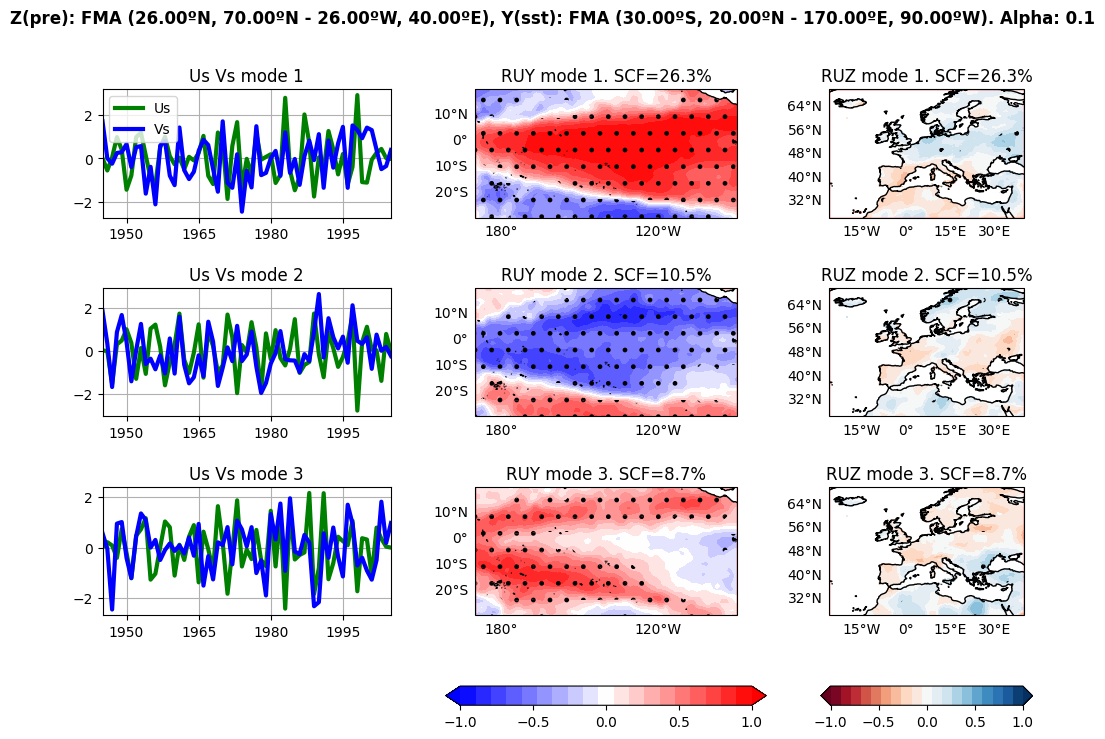

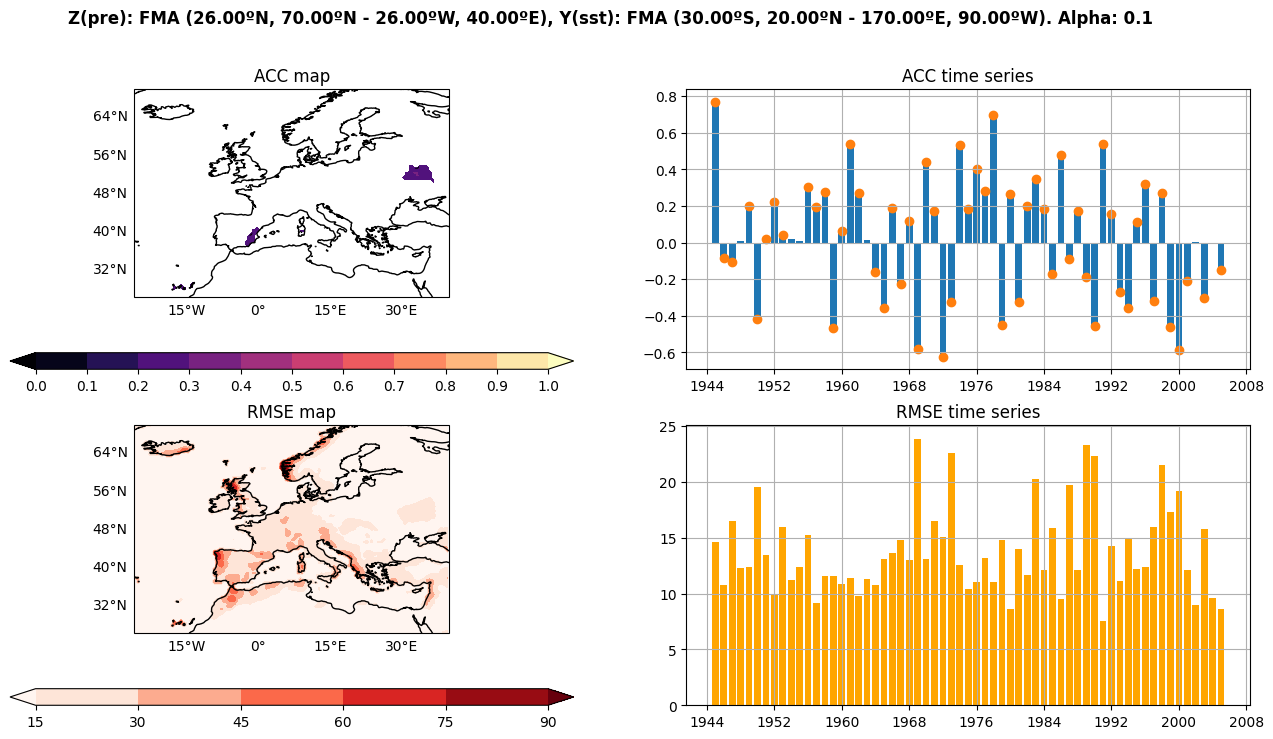

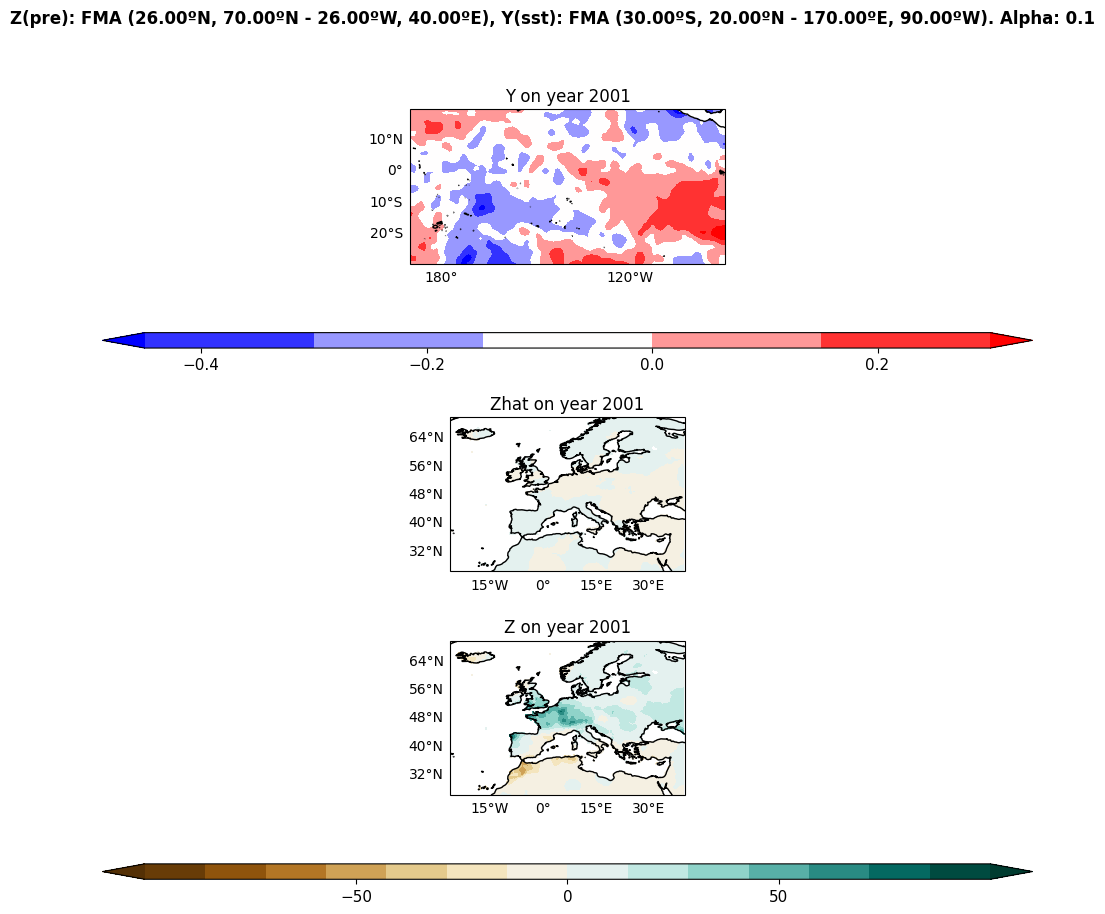

In [9]:
mca.plot(
    save_fig=True, cmap="RdBu", name="mca.png",
    folder="./plots-Pacific_Impact_European_Rainfall/",
    ruy_ticks=[-1, -0.5, 0, 0.5, 1],
    ruz_ticks=[-1, -0.5, 0, 0.5, 1],
)
cross.plot(
    save_fig=True, name="cross.png",
    folder="./plots-Pacific_Impact_European_Rainfall/",
    cmap="magma", 
    map_ticks=np.arange(0, 1.001, .1),
    map_levels=np.arange(0, 1.001, .1),
)
cross.plot_zhat(2001, figsize=(12, 10), save_fig=True, name="zhat_1999.png", 
                folder="./plots-Pacific_Impact_European_Rainfall/", cmap="BrBG", 
                z_levels=np.linspace(-100, 100, 15))

In [7]:
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

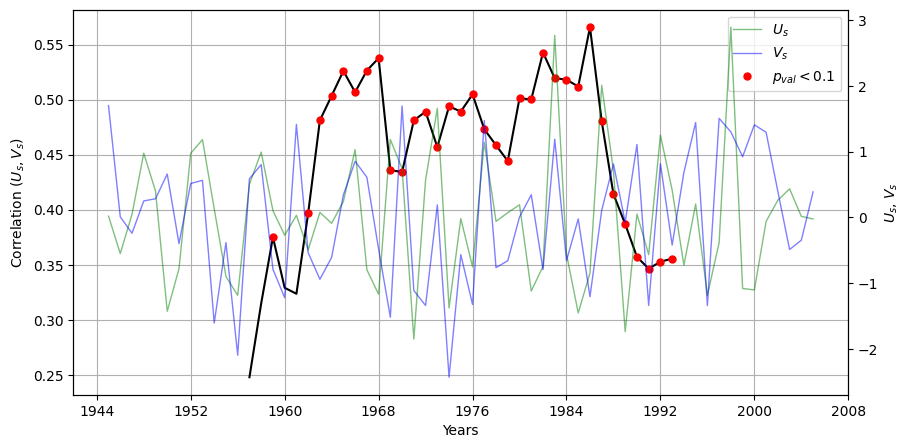

In [8]:
nt = mca.Us[0].shape[0]

win = 25
rs = np.zeros(nt - win + 1, float)
ps = np.zeros(nt - win + 1, float)
years = np.zeros((nt - win + 1, 2), int)
for i in range(nt - win + 1):
    u = mca.Us[0, i:i+win]
    v = mca.Vs[0, i:i+win]
    years[i, :] = mca.dsz.time[i], mca.dsz.time[i+win-1]
    rs[i], ps[i] = stats.pearsonr(u, v)


alpha = 0.1
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()

ax_uv = ax.twinx()
ln1, = ax_uv.plot(mca.dsz.time, mca.Us[0], color="green", label="$U_s$", alpha=0.5, linewidth=1)
ln2, = ax_uv.plot(mca.dsz.time, mca.Vs[0], color="blue", label="$V_s$", alpha=0.5, linewidth=1)
ax_uv.set_ylabel("$U_s$, $V_s$")

center_years = years.mean(axis=1)
ax.plot(center_years, rs, color="black")
ln3, = ax.plot(center_years[ps < alpha], rs[ps < alpha], ".", markersize=10, color="red", label="$p_{val} < 0.1$")
#labels = [rf"${years[i, 0]} \rightarrow {years[i, 1]}$" for i in range(years.shape[0])]
step = 5
ax.xaxis.set_major_locator(MaxNLocator(10))
#ax.xaxis.set_ticks(mca.dsz.time[::step])
#ax.xaxis.set_ticklabels(labels[::step], rotation=20)
ax.set_ylabel("Correlation $(U_s, V_s)$")
ax.set_xlabel("Years")

ax.grid()
lns = [ln1, ln2, ln3]
ax.legend(handles=lns)

We can safely say that the relation is stationary and the correlation significative from 1965 to 1984 

In [9]:
predictor2 = Dataset("HadISST_sst_chopped.nc", "./datasets").open("sst").slice(
    Region(lat0=-30, latf=20,
           lon0=-190, lonf=-90,
           month0=Month.FEB, monthf=Month.APR,
           year0=1965, yearf=1984),
)

predictand2 = Dataset("cru_ts4_pre_chopped.nc", "./datasets").open("pre").slice(
    Region(lat0=26, latf=70,
           lon0=-26, lonf=40,
           month0=Month.FEB, monthf=Month.APR,
           year0=1965, yearf=1984),
    skip=0,  # It is a very big matrix so we skip some values to reduce the size
)
predictor_preprocessed2 = Preprocess(predictor2, period=7, order=4)
predictor_preprocessed2.save("y2_", "./data-Pacific_Impact_European_Rainfall/")
# predictor_preprocessed2 = Preprocess.load("y2_", "./data-Pacific_Impact_European_Rainfall/")
predictand_preprocessed2 = Preprocess(predictand2)
predictand_preprocessed2.save("z2_", "./data-Pacific_Impact_European_Rainfall/")
# predictand_preprocessed2 = Preprocess.load("z2_", "./data-Pacific_Impact_European_Rainfall")
nm = 3
alpha = 0.1
mca2 = MCA(predictor_preprocessed2, predictand_preprocessed2, nm, alpha)
mca2.save("mca2_", "./data-Pacific_Impact_European_Rainfall/")
# mca2 = MCA.load("mca2_", "./data-Pacific_Impact_European_Rainfall/", dsy=predictor_preprocessed, dsz=predictand_preprocessed)
cross2 = Crossvalidation(predictor_preprocessed2, predictand_preprocessed2, nm, alpha, num_svdvals=nm)  # num_svdvals is used to reduce runtime as we do not need scf
cross2.save("cross2_", "./data-Pacific_Impact_European_Rainfall/")
#cross2 = Crossvalidation.load("cross2_", "./data-Pacific_Impact_European_Rainfall/", dsy=predictor_preprocessed, dsz=predictand_preprocessed)

[INFO] Preprocessing data for variable sst took: 0.459 seconds
[INFO] Saving Preprocess data in `./data-Pacific_Impact_European_Rainfall/y2_*.npy`
[INFO] Preprocessing data for variable pre took: 0.046 seconds
[INFO] Saving Preprocess data in `./data-Pacific_Impact_European_Rainfall/z2_*.npy`
[INFO] Applying MCA 
    Shapes: Z(11616, 20) 
            Y(5000, 20) 
    Regions: Z FMA (26.00ºN, 70.00ºN - 26.00ºW, 40.00ºE) 
            Y FMA (30.00ºS, 20.00ºN - 170.00ºE, 90.00ºW)
       Took: 41.647 seconds
[INFO] Saving MCA data in `./data-Pacific_Impact_European_Rainfall/mca2_*.npy`
[INFO] Applying Crossvalidation 
    Shapes: Z(11616, 20) 
            Y(5000, 20) 
    Regions: Z FMA (26.00ºN, 70.00ºN - 26.00ºW, 40.00ºE) 
            Y FMA (30.00ºS, 20.00ºN - 170.00ºE, 90.00ºW)
	year: 1 of 20
	year: 2 of 20
	year: 3 of 20
	year: 4 of 20
	year: 5 of 20
	year: 6 of 20
	year: 7 of 20
	year: 8 of 20
	year: 9 of 20
	year: 10 of 20
	year: 11 of 20
	year: 12 of 20
	year: 13 of 20
	year: 14 of 2

[INFO] Saving plot with path ./plots-Pacific_Impact_European_Rainfall/mca.png
[INFO] Saving plot with path ./plots-Pacific_Impact_European_Rainfall/cross.png


((<Figure size 1600x800 with 6 Axes>,),
 (<GeoAxesSubplot:title={'center':'ACC map'}>,
  <AxesSubplot:title={'center':'ACC time series'}>,
  <GeoAxesSubplot:title={'center':'RMSE map'}>,
  <AxesSubplot:title={'center':'RMSE time series'}>))

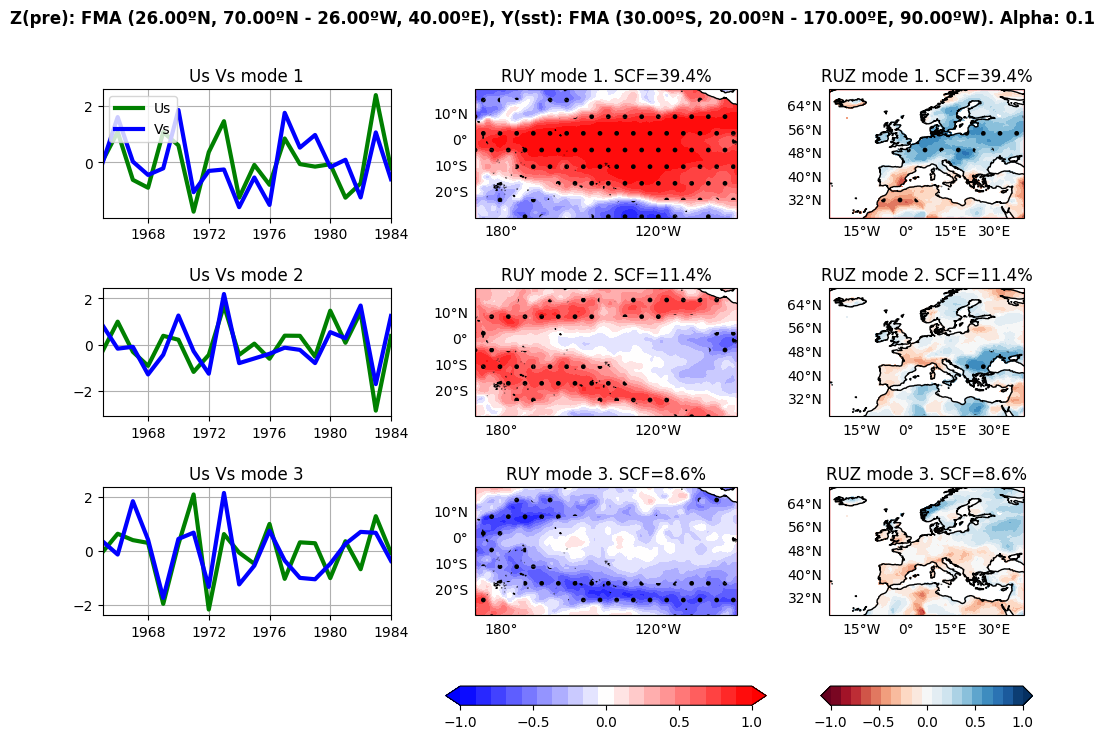

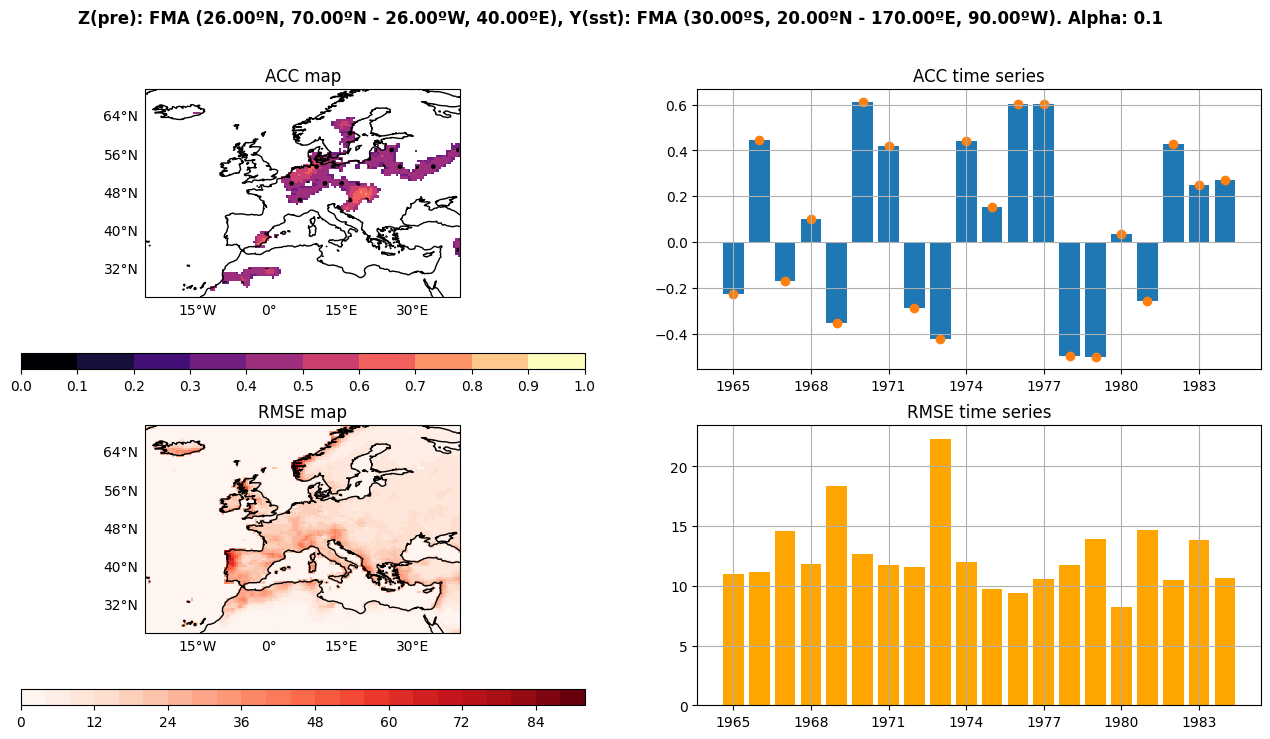

In [10]:
mca2.plot(
    save_fig=True, cmap="RdBu", name="mca.png",
    folder="./plots-Pacific_Impact_European_Rainfall/",
    ruy_ticks=[-1, -0.5, 0, 0.5, 1],
    ruz_ticks=[-1, -0.5, 0, 0.5, 1],
)
cross2.plot(
    save_fig=True, name="cross.png",
    folder="./plots-Pacific_Impact_European_Rainfall/",
    cmap="magma", 
    map_ticks=np.arange(0, 1.001, .1),
    map_levels=np.arange(0, 1.001, .1),
    plot_type="pcolor",
)